Author: Sean Tulin
<br>
Date: Feb. 9, 2022
<br>
PHYS 2030 W22

# <font color=#46769B>Lesson 7: Markov Chain Monte Carlo for continuous distributions</font>

## <font color=#46769B>Motivation</font>

Let us generalize our discussion from Lesson 6 to the case of probability distribution functions of continuous variables. 



## <font color=#46769B>Metropolis algorithm for continuous distributions</font>

Suppose we have a target PDF $P(x)$, where $x$ is a continuous variable that we want to sample. To be concrete, let's consider an exponential function
$$P(x) = \left\{ \begin{array}{cc} a e^{-ax} & x > 0 \\ 0 & {\rm otherwise} \end{array} \right. \, .$$ 
For future reference, we recall that the true mean and standard deviation of this distribution are $\mu = \sigma = 1/a$.

The general procedure for performing an MCMC simulation is generally the same as for a discrete variable. 

### <font color=#46769B>Choosing your proposal distribution</font>

First, we need to decide on a proposal (transition) PDF $Q(x|x^\prime)$. In the Metropolis algorithm, the proposal distribution is assumed to be symmetric, i.e.,
$$Q(x|x^\prime) = Q(x^\prime|x) \, .$$
In this course, we will always choose a __normal distribution__ for our proposal distribution: 
$$Q(x|x^\prime) = \frac{1}{\sqrt{2\pi \sigma_q^2}} \, e^{-\frac{(x-x^\prime)^2}{2 \sigma_q^2}} \, .$$
That is, you draw the *new* sample $x$ from a normal distribution centered at the *old* sample $x^\prime$. 
This choice for $Q(x|x^\prime)$ is the most common one for MCMC simulations, in part because it is clearly symmetric (it is invariant under $x \leftrightarrow x^\prime$).

We still have a choice to make: we are free to choose any value for the width of our proposal distribution, $\sigma_q$. (We label it $\sigma_q$ to make it clear that it is related to the proposal PDF $Q$ and not to be confused with the true $\sigma$ from our target PDF $P$.)

There is always a "sweet spot" where $\sigma_q$ is neither too large nor too small, where your simulation will be optimized.
We will gain some experience in how to optimize $\sigma_q$ below.

Let's summarize the main idea of how to choose the best $\sigma_q$. The main goal of our MCMC simulation is to obtain a list of $x$ samples
$$(x_0, \, x_1, \, x_2, \, ... , \, x_{N-1})$$
that are scattered diversely throughout the region of maximum probability. Consider the figure below. The darker shaded region represents the region of higher probability and the green point represents $x^\prime$. (For visual clarity, the picture represents sampling two variables in a plane, say, $x$ and $y$.)

<div>
<img src="https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/raw/main/figures/MCMC_step_size.png" width="600">
</div>

- If $\sigma_q$ is large, we are more likely to make larger steps in $x$. After a large step, $x$ will be far outside the most probable region. Such new points are unlikely to be accepted, and we end up with the same point $x^\prime$ repeated in our chain.

- If $\sigma_q$ is small, we are more likely to make smaller steps in $x$. Since each new step $x$ is near the old point $x^\prime$, the acceptance ratio is close to one and new points are likely to be accepted. However, we end up with many points that are closely correlated with each other.

- If $\sigma_q$ is just right, the step size will be comparable to the size of the region we want to sample from. We will have a mix of accepted and rejected samples.

In practice, it is important to __tune__ your MCMC to determine the best value of $\sigma_q$. This is similar to the iterative tuning we did for importance sampling.


### <font color=#46769B>Acceptance/rejection</font>

The process for accepting or rejecting a new sample is the same as we discussed for a discrete distribution. Here we recap the steps:
- Given a previous sample $x^\prime = x_{i-1}$, generate a new sample $x$ by sampling from $Q(x|x_{i-1})$.
- Calculate the acceptance ratio $\mathcal{A} = P(x)/P(x_{i-1})$.
    - If $\mathcal{A} > 1$, we *always* accept the new point.
    - If $\mathcal{A} < 1$, we *either* accept or reject the new point. We decide to accept or reject randomly: we accept with probability $\mathcal{A}$ (and therefore we reject with probability $1-\mathcal{A}$).
- The next value in the chain, $x_i$, depends on whether we accept or reject:
    - If we accept $x$, we set $x_i = x$, i.e., saving our new sample to the chain.
    - If we reject $x$, we set $x_i = x_{i-1}$, i.e., *repeating our previous value in the chain*. 

There is a __remarkable thing__ about MCMC algorithms that is worthwhile to notice. The target PDF $P(x)$ only enters in the acceptance ratio $A = P(x)/P(x^\prime)$. Because $\mathcal{A}$ is the *ratio* of the probabilities at two different points, the *normalization* of $P(x)$ is actually irrelevant. In practice, especially for multivariate sampling problems, finding the normalization is either challenging or impractical. For MCMC algorithms, we do not need to normalize our target PDF.

### <font color=#46769B>Summary</font>

Let's summarize how we implement the Metropolis algorithm for sampling from our exponential PDF $P(x)$, with $a=1$.

Before we begin, we need to choose:
- An initial value for the chain, $x_0$. Let's choose $x_0 = 1$.
- The transition PDFs $Q(x|x^\prime)$. Let's choose a normal distribution with $\sigma_q=1$.
- The number of samples $N$ we want in our chain. Let's try $N=10^5$.

Next, we do a `for` loop over an index `i` that will generate $N$ entries in our chain. For each iteration in the `for` loop:
- Given $x_{i-1}$, generate a new sample $x$ from $Q(x|x_{i-1})$. Recall, this means we are sampling from a normal distribution centered at mean $x_{i-1}$ with width $\sigma_q$ to get $x$. The line of code that does this is
```py
x = np.random.normal(x_old,sigma)
```
where `x_new` is our new sample $x$ and `x_old` is $x_{i-1}$. Note that there is no `num` appearing here. We are only getting the next *one* sample in the chain.
- Calculate the acceptance ratio $\mathcal{A} = P(x)/P(x_{i-1})$.
- Acceptance/rejection step:
    - If accept, set $x_i = x$. 
    - Else (reject), set $x_i = x_{i-1}$, i.e., repeat the previous value.

After $N-1$ iterations, the `for` loop terminates (we started with one sample $x_0$ to begin with). Our chain consists of $N$ samples for $x$:
$$x = \left( x_0, \, x_1, \, x_2, \, ... , \, x_{N-1}\right) \, .$$
Now, we can calculate anything we like as if we had sampled from $P(x)$ directly. For example, the mean value of $x$ is
$$\langle x \rangle = \frac{1}{N} \sum_{i=0}^{N-1} x_i \, .$$
The mean value of any function of $x$ is
$$\langle f(x) \rangle = \frac{1}{N} \sum_{i=0}^{N-1} f(x_i) \, .$$
Unlike importance sampling, we do not need to include any weights in our calculations.

Here is some code that implements all this. We will also calculate the mean and standard deviation. Recall that the true mean and standard deviations are equal to $\mu = a$ and $\sigma=a$, respectively.

In [37]:
import numpy as np
import matplotlib.pyplot as plt

num = 10**5
a = 1
x0 = 1
sigma = 1

# Define P(x)
def P(x):
    return np.where( x >= 0, a*np.exp(-a*x), 0 )
    
# Initialize the first value in the chain [x0]
x_samples = [x0]

for i in range(num-1):
    
    # Previous value of x
    x_old = x_samples[i]
    
    # Sample new value of x
    x_new = np.random.normal(x_old,sigma)
    
    # Acceptance ratio
    A = P(x_new)/P(x_old)
    
    # Check whether accept or reject
    
    # Accept always
    if A > 1:
        x_samples.append(x_new)
    
    # Accept with probability A
    else:
        # Randomly decide to accept
        r = np.random.rand()
        if r < A:
            x_samples.append(x_new)
        else:
            x_samples.append(x_old)

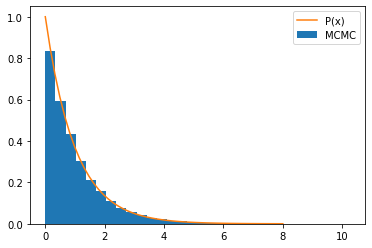

In [39]:
# Plot a histogram of our sample
plt.hist(x_samples,bins=30,density=True,label='MCMC')

# Compare to our PDF
x = np.linspace(0,8)
plt.plot(x,P(x),label='P(x)')

plt.legend()
plt.show()

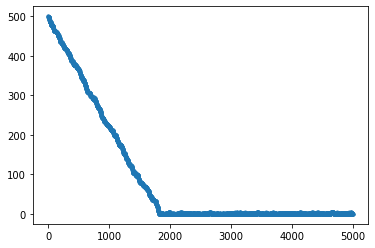

In [35]:
plt.plot(x_samples[:5000],'.')

## <font color=#46769B>Markov Chain Monte Carlo</font>

MCMC is a different algorithm for sampling $x$ from a probability distribution $P(x)$. Before we discuss the algorithm, let's highlight the main differences with importance sampling.
- MCMC involves a proposal distribution $Q$ that you are free to choose. Unlike importance sampling, $Q$ *depends* on the previous sample. We write this as: $$Q(x|x^\prime)$$
This the probability to sample $x$ *given* that the previous sample was $x^\prime$. $Q(x|x^\prime)$ is known as a __transition probability__.
- MCMC generates samples for $x$ that are drawn from the *target* distribution $P(x)$ directly. *No weights are needed.* Importance sampling draws samples for $x$ from the *proposal* distribution and we needed to include weights to calculate quantities with respect to $P(x)$. 
- In MCMC, after drawing each sample $x_i$, there is an additional step where you must decide whether or not to accept the sample. This is known as the __acceptance/rejection step__.

The list of samples for $x$ is called a __chain__. Since each new sample depends on the one before, MCMC is an iterative process where you build your chain one sample at a time until it has the desired length $N$.

Now we will go through in detail how (and why!) MCMC works for the coin flip example.

### <font color=#46769B>Transition probabilities</font>

The first step is to choose your transition probabilities $Q(x|x^\prime)$. For flipping a coin, the only choice is a Bernoulli distribution, but it will depend on whether the previous sample $x^\prime$ was heads or tails.

Suppose our previous sample is tails ($x^\prime = 0$). Then we say the probability of getting heads or tails for the next sample $x$ is
$$Q(x|0) = \left\{ \begin{array}{cl} q & x=1  \\ 1-q & x=0 \end{array} \right. \, .$$
Now suppose our previous sample is heads ($x^\prime = 1$). Then we say the probability of getting heads or tails for the next sample $x$ is
$$Q(x|1) = \left\{ \begin{array}{cl} \bar{q} & x=1  \\ 1-\bar{q} & x=0 \end{array} \right. \, .$$
That is, $Q(x|0)$ and $Q(x|1)$ are different distributions. 
Of course, the total probability for *either* $x=1$ or $x=0$ is always unity, so we must have
$$Q(1|0) + Q(0|0) = q + (1-q) = 1 \, , \qquad  Q(1|1) + Q(0|1) = \bar{q} + (1-\bar{q}) = 1 \, .$$
However, $q$ and $\bar{q}$ are different in general and we are free to choose them as we like.

We can make a map to illustrate all the different possible transitions and their probabilities:
<div>
<img src="https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/raw/main/figures/MCMC_coin_flip.png" width="600">
</div>


The most common (and original) type of MCMC is known as the __Metropolis algorithm__. This is the main algorithm we will use in this course. In the Metropolis algorithm, we make an assumption that the transition probability is *symmetric*,
$$Q(x|x^\prime) = Q(x^\prime|x) \, ,$$
so the probablity of sampling $x^\prime \to x$ is the same as sampling $x \to x^\prime$.
For the coin flip, the Metropolis algorithm assumes $Q(0|1) = Q(1|0)$, i.e., taking a special choice that $\bar{q} = 1-q$.

The more general MCMC setup where $Q(x|x^\prime) \ne Q(x^\prime|x)$ is known as the __Metropolis-Hastings algorithm__.
For the coin flip, Metropolis-Hastings simply allows $q$, $\bar{q}$ to be independent.

### <font color=#46769B>Acceptance/rejection</font>

It is an important step in MCMC algorithms to decide whether to accept or reject a new sample. The process is:
- Given a previous sample $x_{i-1}$, generate a new sample $x$ by sampling from $Q(x|x_{i-1})$.
- Calculate the acceptance ratio $\mathcal{A}$, defined below. (Note $\mathcal{A}$ is always a positive number.)
    - If $\mathcal{A} > 1$, we *always* accept the new point.
    - If $\mathcal{A} < 1$, we *either* accept or reject the new point. We decide to accept or reject randomly: we accept with probability $\mathcal{A}$ (and therefore we reject with probability $1-\mathcal{A}$).
- The next value in the chain, $x_i$, depends on whether we accept or reject:
    - If we accept $x$, we set $x_i = x$, i.e., saving our new sample to the chain.
    - If we reject $x$, we set $x_i = x_{i-1}$, i.e., *repeating our previous value in the chain*. 
    
It is easy to forget this last step. Rejection does not mean you try to find a new accepted sample for $x_i$. Rejection means that you *repeat* the previous sample. If you reject ten times in a row, you will be repeating the same values in your chain ten times.

For the Metropolis algorithm, the acceptance ratio is
$$\mathcal{A}(x,x^\prime) = \frac{P(x)}{P(x^\prime)}$$
where $x$ is the new sample and $x^\prime$ is the previous sample (i.e., $x_{i-1}$). Thus, if $\mathcal{A}(x,x^\prime) > 1$, that means that $x$ is *more probable* than $x^\prime$. We always keep such points in our sample.

On the other hand, we do not *always* reject samples where $\mathcal{A}(x,x^\prime) < 1$. 
For example, let's suppose $\mathcal{A}(x,x^\prime) = 0.1$. This means that $x$ is only 10\% as probable as $x^\prime$. The procedure described above will accept such samples 10\% of the time.

For the Metropolis-Hastings algorithm, the acceptance ratio is given by a more complicated formula
$$\mathcal{A}(x,x^\prime) = \frac{P(x)}{P(x^\prime)} \frac{Q(x^\prime|x)}{Q(x|x^\prime)} \, .$$
Clearly if $Q(x|x^\prime) = Q(x^\prime|x)$, we reduce to the result for the Metropolis algorithm.



In [16]:
import numpy as np

p = 0.7
num = 10**5

# Define P(x)
# Note: P[0] = 1-p (tails)
#       P[1] = p   (heads)

P = [1-p, p]

# Initialize the first value in the chain [x0]
x_samples = [0]

for i in range(num-1):
    
    # Previous value of x
    x_old = x_samples[i]
    
    # Sample new value of x
    x_new = np.random.choice([0,1])
    
    # Acceptance ratio
    A = P[x_new]/P[x_old]
    
    # Check whether accept or reject
    
    # Accept always
    if A > 1:
        x_samples.append(x_new)
    
    # Accept with probability A
    else:
        # Randomly decide to accept
        r = np.random.rand()
        if r < A:
            x_samples.append(x_new)
        else:
            x_samples.append(x_old)


Now, we can check that we are getting sensible numbers out. Recall that the true mean and standard deviation of a Bernoulli distribution are $\mu = p$ and $\sigma = \sqrt{p(1-p)}$.

In [17]:
print("The true mean is", p)
print("Our estimated mean is", np.mean(x_samples))
print("The true standard deviation is", np.sqrt(p*(1-p)))
print("Our estimated standard deviation is", np.std(x_samples))

The true mean is 0.7
Our estimated mean is 0.69983
The true standard deviation is 0.45825756949558405
Our estimated standard deviation is 0.45833172604566663


We never explicitly specified the proposal distribution $Q$ in our code ($q$ does not appear anywhere). However, we did this implicitly in `numpy.random.choice` since by default it chooses between the two options with equal probability. This worked since we had chosen $q=0.5$.

Notice that although we are sampling heads and tails equally (with `numpy.random.choice`), we are not getting out a mean $\langle x \rangle = 0.5$. The acceptance/rejection step is essential here for ensuring that our samples correspond to $P$ even though we are sampling from $Q$.

## <font color=#46769B>Proof</font>

Here we prove that MCMC algorithm really does generate samples for $P$. To be general, we will consider the more general Metropolis-Hastings algorithm. As above, we will consider a Bernoulli distribution to keep things simple. The arguments are similar with more complicated probability distributions, but we will not show them here.

Suppose we have a given sample $x_i$. Let's calculate the probability the next sample $x_{i+1}$ is heads or tails according to the Metropolis-Hastings algorithm.

First of all, we don't know whether $x_i$ is heads or tails. Let's assign a probability $f$ that $x_i$ is heads and $1-f$ that is tails. That is, if we ran many MCMC simulations, $x_i$ would be heads a fraction $f$ of the time and tails a fraction $1-f$ of the time. 

Now, there are three ways that $x_{i+1}$ could be heads:
- $x_i$ is tails and there is a transition $0 \to 1$ that is accepted.
- $x_i$ is heads and there is a transition $1 \to 1$. (Such a transition is always accepted since $\mathcal{A}(1,1) = 1$.)
- $x_i$ is heads and there is a transition $1 \to 0$ that is rejected.

The sum of these three probabilities is:
$${\rm Prob}(x_{i+1} = 1) = \underbrace{(1-f)}_{{\rm Prob.} \; x_i = 0} \times \underbrace{Q(1|0)}_{{\rm Prob.} \; 0\to 1} 
\times \underbrace{\mathcal{A}(1,0)}_{{\rm Prob.\; accept}} + 
\underbrace{f}_{{\rm Prob.} \; x_i = 1} \times \underbrace{Q(1|1)}_{{\rm Prob.} \; 1\to 1} 
\times \underbrace{\mathcal{A}(1,1)}_{{\rm Prob.\; accept}} + 
\underbrace{f}_{{\rm Prob.} \; x_i = 1} \times \underbrace{Q(0|1)}_{{\rm Prob.} \; 1\to 0} 
\times \underbrace{(1 - \mathcal{A}(0,1))}_{{\rm Prob.\; reject}}$$
Now we can plug in our expressions for $Q$ and $\mathcal{A}$ given above:
$${\rm Prob}(x_{i+1} = 1) = (1-f)\times q \times {\rm min}\left( \frac{p}{1-p} \frac{1-\bar q}{q}, 1 \right) 
+ f \times \bar{q} + f \times (1-\bar q) \times \left(1 - {\rm min}\left( \frac{1-p}{p} \frac{q}{1-\bar q}, 1 \right)\right) \, .$$
With some algebra we can write this as
$${\rm Prob}(x_{i+1} = 1) = f + \left[ \frac{1-f}{1-p} - \frac{f}{p} \right] \times {\rm min}\left( p(1-\bar q), q(1-p) \right) \, . \qquad (1)$$

The most interesting solutions to this equation are __stationary__ solutions. This means that the probability of finding heads for sample $x_{i+1}$ is equal to the probability of finding heads for $x_i$.
That is, we set the above Eq. (1) equal to $f$:
$${\rm Prob}(x_{i+1} = 1) = f + \left[ \frac{1-f}{1-p} - \frac{f}{p} \right] \times {\rm min}\left( p(1-\bar q), q(1-p) \right) = f \, .$$
The only solution is where the term in brackets is zero,
$$\frac{1-f}{1-p} - \frac{f}{p}  = 0 \, ,$$
which requires that $f = p$.

Let's paraphrase our arguments: 
- If we run our MCMC algorithm for many iterations, we expect our samples to converge to *some* unique stationary distribution, where the probability of getting heads or tails converges to a fixed value. (There are some technical requirements in order for this to be achieved; further reading can be found [here](https://similarweb.engineering/mcmc/).) 
- According to the Metropolis-Hastings algorithm (which includes the Metropolis algorithm as a special case), the stationary distribution is where a fraction $p$ of the samples are heads. (This implies obviously, though we did not show it explicitly, that a fraction $1-p$ of the samples are tails.)

This is exactly what we wanted: our samples reproduce the target distribution $P(x)$.

### <font color=#46769B>Caveat</font>

The most important thing to remember about MCMCs is that *only the stationary distribution reproduces the target distribution $P(x)$*.

To pick an extreme example, suppose we have a coin that is very biased toward heads, with $p=0.99$. But suppose we start our chain with tails, $x_0 = 0$, and run the Metropolis algorithm with $q = 0.01$. Since $Q(0|0) = 1-q = 99\%$, we are very likely to sample many tails in a row before getting heads. Obviously, getting 50 or 100 tails in a row is not representative of the target probability distribution $P(x)$ that is strongly biased towards heads!

While we are guaranteed to converge to a stationary distribution *eventually* that reproduces $P(x)$, the first samples of our chain many not reproduce $P(x)$ at all. In practice, the following rules apply:
- One needs to discard the beginning of the chain, which is known as the __burn-in__ period. The burn-in period is simply the part of your chain where the algorithm is converging to its stationary distribution.
- There are good proposal distributions and bad proposal distributions, and there are good initial points $x_0$ and bad ones. Good choices can make the burn-in period small or even zero, while bad choices can prevent your MCMC from burning-in within a reasonable amount of time.

